# TIME SERIES ANALYSIS

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

## Return Forecasting: 
Read Historical Daily Yen Futures Data¶

In [4]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("C:/Users/Endalkachew Desta/downloads/Time-Series-Homework-Instructions-Starter_Code/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [5]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


### Return Forecasting: Initial Time-Series Plotting¶

<AxesSubplot:xlabel='Date'>

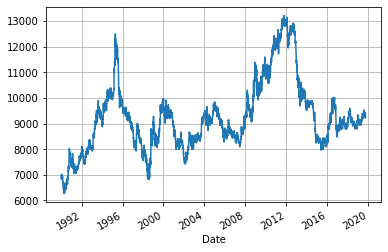

In [6]:
# Plot of the "Settle" column from the dataframe:
yen_futures.Settle.plot(grid=True)

## Decomposition Using a Hodrick-Prescott Filter

In [7]:
import statsmodels.api as sm

# Decompose the time series data into trend and residual(noise)

ts_noiseg, ts_trendg = sm.tsa.filters.hpfilter(yen_futures.Settle)

<AxesSubplot:title={'center':'Noise of the time series data'}, xlabel='Date'>

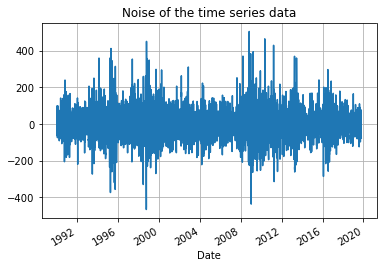

In [8]:
# Plot signal Noise
ts_noiseg.plot(title='Noise of the time series data', grid=True)

<AxesSubplot:title={'center':'Trend of the time series data'}, xlabel='Date'>

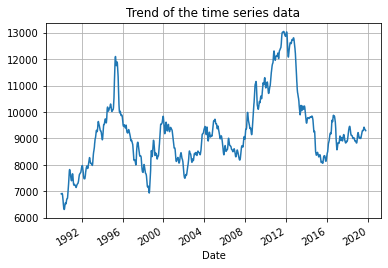

In [9]:
# Trend of the series
ts_trendg.plot(title='Trend of the time series data', grid=True)

In [10]:
# Create a dataframe of just the settle price, and adding columns for "noise" and "trend" series from above:
yen_settle = yen_futures['Settle']

yen_settle = pd.DataFrame(yen_settle)

yen_settle['noise'] = ts_noiseg
yen_settle['trend'] = ts_trendg

yen_settle.dropna()

yen_settle.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle Vs Trend'}, xlabel='Date'>

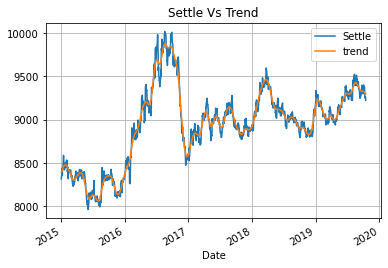

In [11]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_settle_2015 = yen_settle['2015-01-01': ]
yen_settle_2015.plot(y=['Settle','trend'],grid=True,title='Settle Vs Trend')

<AxesSubplot:title={'center':'Noise from 2015 on'}, xlabel='Date'>

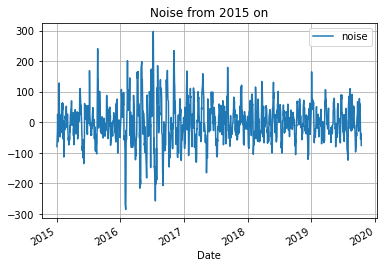

In [12]:
# Plot of the 2015 and on Settle Noise
yen_settle_2015.plot(y=['noise'],grid=True,title='Noise from 2015 on')

## Forecasting Returns using an ARMA Model

In [13]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [14]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [15]:
# Summarize the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Wed, 03 Feb 2021   AIC                          15798.142
Time:                        07:48:31   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3064      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2949      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3326           +0.0000j            3.3326            0.5000
AR.2         -157.0960           +0.0000j          157.0960            0.5000
MA.1           -3.3914           +0.0000j            3.3914            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Return Forcast'}>

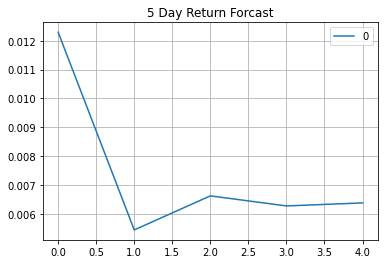

In [16]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Return Forcast",grid=True)

## Forecasting the Settle Price using an ARIMA Model

In [17]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
model = ARIMA(yen_settle['Settle'], order=(5, 1, 1))

# Fit the model
results1 = model.fit()

C:\Users\Endalkachew Desta\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Endalkachew Desta\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [18]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Wed, 03 Feb 2021   AIC                          83905.238
Time:                        07:49:03   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.668       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8918           -1.3787j            2.3409           -0.1002
AR.2            1.8918           +1.3787j            2.3409            0.1002
AR.3           -2.2705           -3.0203j            3.7785           -0.3526
AR.4           -2.2705           +3.0203j            3.7785            0.3526
AR.5          -11.0834           -0.0000j           11.0834           -0.5000
MA.1            3.3643           +0.0000j            3.3643            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'ARIMA 5 Day Return Forcast'}>

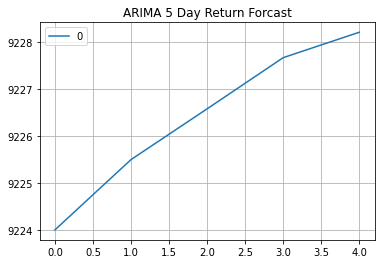

In [19]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results1.forecast(steps=5)[0]).plot(title="ARIMA 5 Day Return Forcast",grid=True)

## Volatility Forecasting with GARCH

In [20]:
import arch 
from arch import arch_model

In [21]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = model.fit(disp="off")

In [22]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Wed, Feb 03 2021   Df Residuals:                     7510
Time:                        07:49:23   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

### Covariance estimator: robust

In [23]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [24]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2009-12-31', horizon=forecast_horizon)
forecasts

In [25]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.tail()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-09,7.376203,7.418705,7.460615,7.501945,7.542708
2019-10-10,7.367164,7.409793,7.451826,7.493278,7.534159
2019-10-11,7.476237,7.517352,7.557905,7.597907,7.637369
2019-10-14,7.389298,7.431617,7.473348,7.514502,7.555094
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [26]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T

final1 = final['2019-10-15']
final1

h.1    7.434048
h.2    7.475745
h.3    7.516867
h.4    7.557426
h.5    7.597434
Name: 2019-10-15 00:00:00, dtype: float64

<AxesSubplot:title={'center':'5 Day Forcast of Volatility'}>

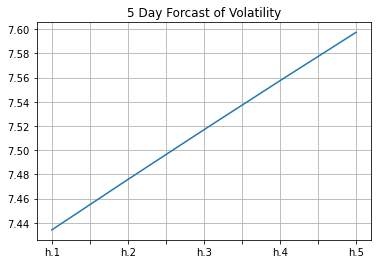

In [27]:
# Plot the final forecast
final1.plot(grid=True, title='5 Day Forcast of Volatility')

### Conclusions

The 5 day forcast of volatility graph shows that the risk of yen is increasing through time. The model provides good data points to better understand the data trend and the noise associated with it. It also provides a reasonably accurate forcast to the future. I would need some more data to make a decision on buying. Based on the return forcast graph for the nexf five days,returns appear to have a somewhat negative trajectory.